# 1. Loading and normalizing MNIST

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
batch_size = 100

transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
classes = list(range(10))
print(len(trainset))
log_freq = len(trainset)//batch_size
print(log_freq)
print(len(testset))

60000
600
10000


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set()

In [4]:
def imshow(img):
    npimg = img.numpy();print(npimg.shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)));print(np.transpose(npimg, (1, 2, 0)).shape)
    plt.show()

torch.Size([100, 1, 28, 28])
(3, 392, 242)
(392, 242, 3)


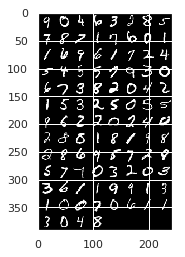

    9     0     4     6


In [5]:
# show images
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.shape)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# 2. Define a Net with IB architecture

In [6]:
import torch.nn as nn
import torch.nn.functional as F

In [7]:
# K is for latent dim
K = 256
num_latent = 12

class Net(nn.Module):
    def __init__(self, K=K, num_latent=num_latent):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 1024)
        self.fc2 = nn.Linear(1024,1024)
        self.enc_mean = nn.Linear(1024, K)
        self.enc_std = nn.Linear(1024, K)
        self.dec = nn.Linear(K, 10)
        self.num_latent = num_latent
        
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.constant_(self.fc1.bias, 0.0)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.constant_(self.fc2.bias, 0.0)
        nn.init.xavier_uniform_(self.enc_mean.weight)
        nn.init.constant_(self.enc_mean.bias, 0.0)
        nn.init.xavier_uniform_(self.enc_std.weight)
        nn.init.constant_(self.enc_std.bias, 0.0)
        nn.init.xavier_uniform_(self.dec.weight)
        nn.init.constant_(self.dec.bias, 0.0)
        
    def forward(self, x):
        x = x.view(-1, 784)
        x = 2*x - 1. # input normalize to [-1,1]
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        enc_mean, enc_std = self.enc_mean(x), F.softplus(self.enc_std(x)-5)
        latent = enc_mean.unsqueeze(1) + torch.randn((tuple(enc_std.shape)[0],)\
                                        +(self.num_latent,)\
                                        + tuple(enc_std.shape)[1:]).cuda() * enc_std.unsqueeze(1)
        outputs = F.softmax(self.dec(latent),dim=2)
        output = torch.mean(outputs, dim=1)
        return outputs, output, enc_mean, enc_std
    
def update_target(target, original, update_rate):
        for target_param, param in zip(target.parameters(), original.parameters()):
            target_param.data.copy_((1.0 - update_rate) * target_param.data + update_rate*param.data)

# 3. Define a Loss function and optimizer

In [8]:
import torch.optim as optim

In [9]:
CE = nn.CrossEntropyLoss()
betas = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]

def calc_loss(outputs, labels, enc_mean, enc_std, beta=1e-4):
    labels = labels.view(-1,1) * torch.ones(batch_size, num_latent, dtype=torch.long).cuda()
    ce = CE(outputs.view(-1,10), labels.view(-1))
    loss = ce + beta * 0.5 * torch.mean(torch.sum(enc_mean**2 + \
                                        enc_std**2 - torch.log(enc_std**2) - 1,dim=1))
    return loss

In [10]:
def train(beta, epoch, net, net_test, optimizer, log_freq=log_freq):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, output, end_means, enc_stds = net(inputs)
        loss = calc_loss(outputs, labels, end_means, enc_stds, beta)
        loss.backward()
        optimizer.step()
        update_target(net_test, net, 0.001)

        # print statistics
        running_loss += loss.item()
        if (i+1) % log_freq == 0:    # print every 2000 mini-batches
            print('[Epoch : %d, Iter: %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / log_freq))
    return running_loss / log_freq
        
def test(net_test):
    print('Start test')
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs, output, end_means, enc_stds = net_test(inputs)
            _, predicted = torch.max(output, 1)
            c = (predicted == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1


    for i in range(10):
        print('Accuracy of %5s : %.2f %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

    test_score = np.mean([100 * class_correct[i] / class_total[i] for i in range(10)])
    print(test_score)
    return test_score

In [11]:
from tqdm import tqdm_notebook

epoch_num = 200
test_freq = 10
losses = list()
test_scores = list()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train = False

# SAVE
def save(beta, net, net_test):
    net_path = './model/net'+str(beta)+'.pkl'
    net_test_path = './model/net_test'+str(beta)+'.pkl'
    net = net.cpu()
    torch.save(net.state_dict(), net_path)
    net_test = net_test.cpu()
    torch.save(net_test.state_dict(), net_test_path)
    # Place it to GPU back
    net.to(device)
    net_test.to(device)
    return net, net_test
    
def load(beta, net, net_test):
    net_path = './model/net'+str(beta)+'.pkl'
    net_test_path = './model/net_test'+str(beta)+'.pkl'
    # LOAD
    net.load_state_dict(torch.load(net_path))
    net_test.load_state_dict(torch.load(net_test_path))
    # Place it to GPU
    net.to(device)
    net_test.to(device)
    return net, net_test

def main():
    for beta in betas:
        print(beta)
        net = Net()
        net_test = Net()
        if torch.cuda.device_count() > 1:
            print("Let's use",torch.cuda.device_count(),"GPUs!")
            net = nn.DataParallel(net)
            net_test = nn.DataParallel(net_test)
        net.to(device)
        net_test.to(device)
        net_test.load_state_dict(net.state_dict())
        
        optimizer = optim.Adam(net.parameters(), lr=1e-4, betas=(0.5,0.999))
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer,gamma=0.97)

        for i in tqdm_notebook(range(epoch_num)):
            loss_avg = train(beta=beta, net=net, net_test=net_test, optimizer=optimizer, epoch=i)
            losses.append(loss_avg)
            if (i+1) % test_freq == 0:
                test_score = test(net_test)
                test_scores.append(test_score)
            if (i+1) % 2 == 0:
                scheduler.step()
                
        save(beta, net, net_test)

if train:
    main()

# 5. Test for FSGM attack

In [12]:
epsilons = [0, .05, .1, .15, .2, .25, .3]

In [13]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [14]:
def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in tqdm_notebook(test_loader):

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        outputs, output, end_means, enc_stds = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        outputs, output, end_means, enc_stds= model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [15]:
examples = []
fin_acc = []

net = Net()
net_test = Net()
if torch.cuda.device_count() > 1:
    print("Let's use",torch.cuda.device_count(),"GPUs!")
    net = nn.DataParallel(net)
    net_test = nn.DataParallel(net_test)
# MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(testset,batch_size=1, shuffle=True)

# Run test for each epsilon
for beta in betas:
    print(beta)
    accuracies = []
    net, net_test = load(beta, net, net_test)
    for eps in tqdm_notebook(epsilons):
        acc, ex = test(net_test, device, test_loader, eps)
        accuracies.append(acc)
        examples.append(ex)
    fin_acc.append(accuracies)

Let's use 4 GPUs!
0.1


Epsilon: 0	Test Accuracy = 9733 / 10000 = 0.9733


Epsilon: 0.05	Test Accuracy = 6781 / 10000 = 0.6781


Epsilon: 0.1	Test Accuracy = 1840 / 10000 = 0.184


Epsilon: 0.15	Test Accuracy = 606 / 10000 = 0.0606


Epsilon: 0.2	Test Accuracy = 333 / 10000 = 0.0333


Epsilon: 0.25	Test Accuracy = 219 / 10000 = 0.0219


Epsilon: 0.3	Test Accuracy = 223 / 10000 = 0.0223

0.01


Epsilon: 0	Test Accuracy = 9841 / 10000 = 0.9841


Epsilon: 0.05	Test Accuracy = 8894 / 10000 = 0.8894


Epsilon: 0.1	Test Accuracy = 7662 / 10000 = 0.7662


Epsilon: 0.15	Test Accuracy = 5809 / 10000 = 0.5809


Epsilon: 0.2	Test Accuracy = 4309 / 10000 = 0.4309


Epsilon: 0.25	Test Accuracy = 3353 / 10000 = 0.3353


Epsilon: 0.3	Test Accuracy = 2619 / 10000 = 0.2619

0.001


Epsilon: 0	Test Accuracy = 9842 / 10000 = 0.9842


Epsilon: 0.05	Test Accuracy = 8914 / 10000 = 0.8914


Epsilon: 0.1	Test Accuracy = 7517 / 10000 = 0.7517


Epsilon: 0.15	Test Accuracy = 5606 / 10000 = 0.5606


Epsilon: 0.2	Test Accuracy = 4061 / 10000 = 0.4061


Epsilon: 0.25	Test Accuracy = 2937 / 10000 = 0.2937


Epsilon: 0.3	Test Accuracy = 2082 / 10000 = 0.2082

0.0001


Epsilon: 0	Test Accuracy = 9865 / 10000 = 0.9865


Epsilon: 0.05	Test Accuracy = 8930 / 10000 = 0.893


Epsilon: 0.1	Test Accuracy = 6748 / 10000 = 0.6748


Epsilon: 0.15	Test Accuracy = 3744 / 10000 = 0.3744


Epsilon: 0.2	Test Accuracy = 1510 / 10000 = 0.151


Epsilon: 0.25	Test Accuracy = 553 / 10000 = 0.0553


Epsilon: 0.3	Test Accuracy = 215 / 10000 = 0.0215

1e-05


Epsilon: 0	Test Accuracy = 9870 / 10000 = 0.987


Epsilon: 0.05	Test Accuracy = 8864 / 10000 = 0.8864


Epsilon: 0.1	Test Accuracy = 5905 / 10000 = 0.5905


Epsilon: 0.15	Test Accuracy = 2515 / 10000 = 0.2515


Epsilon: 0.2	Test Accuracy = 875 / 10000 = 0.0875


Epsilon: 0.25	Test Accuracy = 360 / 10000 = 0.036


Epsilon: 0.3	Test Accuracy = 244 / 10000 = 0.0244

1e-06


Epsilon: 0	Test Accuracy = 9872 / 10000 = 0.9872


Epsilon: 0.05	Test Accuracy = 8714 / 10000 = 0.8714


Epsilon: 0.1	Test Accuracy = 4972 / 10000 = 0.4972


Epsilon: 0.15	Test Accuracy = 2262 / 10000 = 0.2262


Epsilon: 0.2	Test Accuracy = 1377 / 10000 = 0.1377


Epsilon: 0.25	Test Accuracy = 1053 / 10000 = 0.1053


Epsilon: 0.3	Test Accuracy = 849 / 10000 = 0.0849



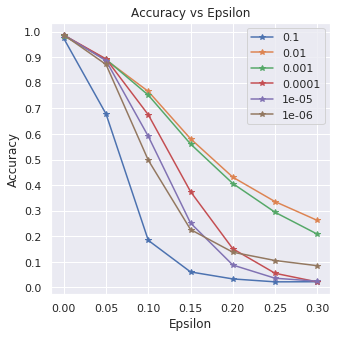

In [16]:
plt.figure(figsize=(5,5))
for i, accuracies in enumerate(fin_acc):
    plt.plot(epsilons, accuracies, "*-",label=str(betas[i]))
plt.legend()
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

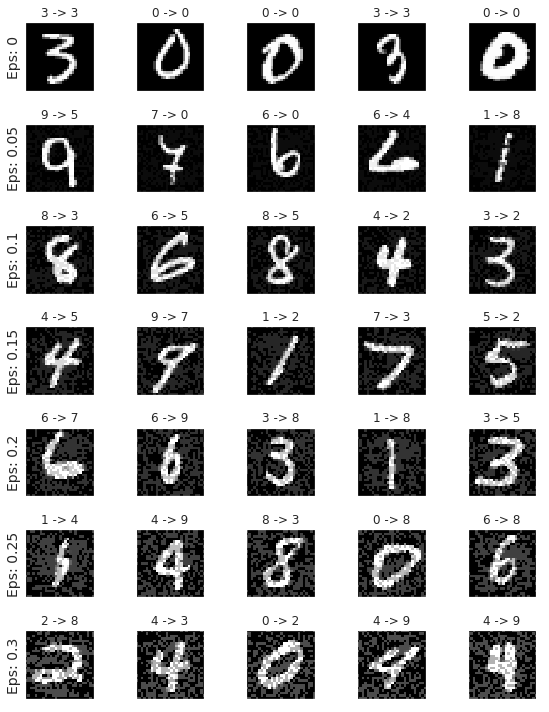

In [17]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

# 6. Application : Variational Discriminator Bottleneck

In [18]:
origin_data = -2 + 0.5 * torch.randn(100)
fake_data = 2 + 0.5 * torch.randn(100)

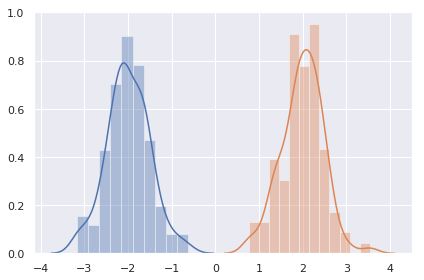

In [19]:
sns.distplot(origin_data)
sns.distplot(fake_data)
plt.tight_layout()
plt.show()

In [20]:
class D(nn.Module):
    def __init__(self, hidden_dim=1024, latent_dim=128, num_latent=1):
        super(D, self).__init__()
        self.fc1 = nn.Linear(1, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.enc_mean = nn.Linear(hidden_dim, latent_dim)
        self.enc_std = nn.Linear(hidden_dim, latent_dim)
        self.dec = nn.Linear(latent_dim, 1)
        self.num_latent = num_latent
        
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.constant_(self.fc1.bias, 0.0)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.constant_(self.fc2.bias, 0.0)
        nn.init.xavier_uniform_(self.enc_mean.weight)
        nn.init.constant_(self.enc_mean.bias, 0.0)
        nn.init.xavier_uniform_(self.enc_std.weight)
        nn.init.constant_(self.enc_std.bias, 0.0)
        nn.init.xavier_uniform_(self.dec.weight)
        nn.init.constant_(self.dec.bias, 0.0)
        
    def forward(self, x):
        x = x.view(-1, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        enc_mean, enc_std = self.enc_mean(x), F.softplus(self.enc_std(x)-5)
        latent = enc_mean.unsqueeze(1)
        outputs = torch.sigmoid(self.dec(latent))
        output = torch.mean(outputs, dim=1)
        return outputs, output, enc_mean, enc_std
    
def calc_loss(outputs, enc_mean, enc_std, Ic=1e-1, beta=1e-1, is_fake=True):
    '''
    We don't use primal-dual GD for solving IB problem here.
    We use Information penalty (like WGAN-GP) heuristic to consider the IB constraint.
    It is more stable than fixed beta method.
    '''
    if is_fake:
        nll = torch.mean(- torch.log(outputs))
        loss = nll \
        + beta * (0.5 * torch.mean(torch.sum(enc_mean**2 \
        + enc_std**2 - torch.log(enc_std**2) - 1,dim=1)) - Ic)**2
    else:
        nll = torch.mean(- torch.log(1-outputs))
        loss = nll \
        + beta * (0.5 * torch.mean(torch.sum(enc_mean**2 \
        + enc_std**2 - torch.log(enc_std**2) - 1,dim=1)) - Ic)**2
    return loss

def train(epoch, net, optimizer, origin_data=origin_data, fake_data=fake_data, beta=1e-1,Ic=1e-1):
    running_loss = 0.0
    # get the inputs
    origin_data = torch.Tensor(origin_data).to(device)
    fake_data = torch.Tensor(fake_data).to(device)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    o_outputs, o_output, o_end_means, o_enc_stds = net(origin_data)
    o_loss = calc_loss(o_outputs, o_end_means, o_enc_stds, is_fake=False, Ic=Ic, beta=beta)
    f_outputs, f_output, f_end_means, f_enc_stds = net(fake_data)
    f_loss = calc_loss(f_outputs, f_end_means, f_enc_stds, is_fake=True, Ic=Ic, beta=beta)
    loss = o_loss + f_loss
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if (epoch+1) % 1000 == 0:
        print('[Epoch : %d] loss: %.3f' %
              (epoch + 1, running_loss))
    return running_loss 

In [21]:
Ics = [10.,1.,1e-2]
fin_out = list()
test_input = torch.Tensor(np.linspace(-4,4,400)).to(device)

for Ic in Ics:
    print(Ic)
    d = D()
    d.to(device)
    optimizer = optim.Adam(d.parameters(),lr=1e-3)
    for epoch in range(3000):
        train(epoch, d, optimizer, Ic=Ic, beta=20.0)
    test_output = d(test_input)[1].detach().cpu().numpy()
    fin_out.append(test_output)

10.0
[Epoch : 1000] loss: 0.042
[Epoch : 2000] loss: 0.008
[Epoch : 3000] loss: 0.003
1.0
[Epoch : 1000] loss: 0.219
[Epoch : 2000] loss: 0.025
[Epoch : 3000] loss: 0.008
0.01
[Epoch : 1000] loss: 6.367
[Epoch : 2000] loss: 1.385
[Epoch : 3000] loss: 0.472


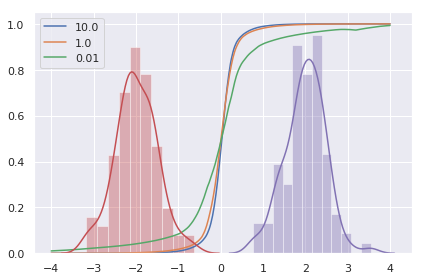

In [22]:
for i, Ic in enumerate(Ics):
    plt.plot(np.linspace(-4,4,400),fin_out[i], label=str(Ic))
sns.distplot(origin_data)
sns.distplot(fake_data)
plt.legend()
plt.tight_layout()
plt.show()